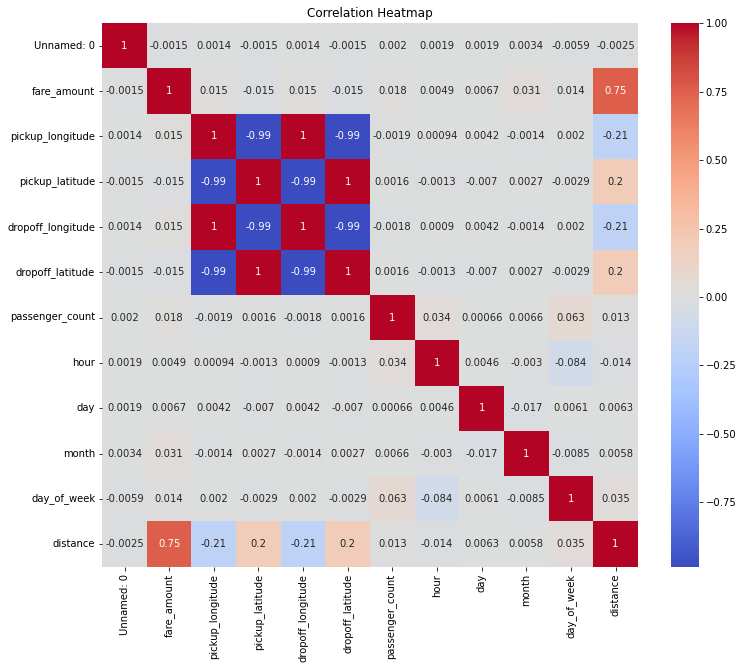

Linear Regression:
  RMSE: 2.4158
  R2: 0.5794
  MAE: 1.7361
  MSE: 5.8360

Random Forest:
  RMSE: 2.3303
  R2: 0.6086
  MAE: 1.6814
  MSE: 5.4305

Model Comparison:
                       RMSE        R2       MAE       MSE
Linear Regression  2.415779  0.579415  1.736102  5.835988
Random Forest      2.330348  0.608636  1.681437  5.430523


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from scipy import stats

# 1. Pre-process the dataset
def preprocess_data(df):
    # Convert pickup_datetime to datetime type
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    
    # Extract additional features from datetime
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    
    # Calculate trip distance using Haversine formula
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in kilometers
        
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        distance = R * c
        return distance
    
    df['distance'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'],
                                        df['dropoff_latitude'], df['dropoff_longitude'])
    
    return df

# 2. Identify outliers
def identify_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# 3. Check the correlation
def check_correlation(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

# 4. Implement and evaluate models
def implement_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MSE': mse}
    
    return results

# Main execution
df = pd.read_csv("C:/Users/yashr/OneDrive/Desktop/Sem 7 LA's/ML Lab Datasets/uber.csv")  # Replace with your actual file name

df = preprocess_data(df)

# Remove outliers
columns_to_check = ['fare_amount', 'distance', 'passenger_count']
df = identify_outliers(df, columns_to_check)

# Check correlation
check_correlation(df)

# Prepare features and target
features = ['passenger_count', 'distance', 'hour', 'day', 'month', 'day_of_week']
X = df[features]
y = df['fare_amount']

# Implement and evaluate models
results = implement_and_evaluate_models(X, y)

# Print results
for model, metrics in results.items():
    print(f"{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

# Create a comparison table
comparison_table = pd.DataFrame(results).T
print("Model Comparison:")
print(comparison_table)